In [1]:
from pysal.model.spvcm.svc import SVC
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Today, we'll sample a spatially-varying coefficient model, like that discussed in [Gelfand (2003)](). These models are of the form:

$$ y_i \sim \mathcal{N}(\mathbf{x}_i'\beta_{i.}, \tau^2)$$
where $\beta_{i.}$ reflects the vector of $p$ coefficient estimates local to site $i$. 
This is a hierarchical model, where a prior on the $\beta$ effects is assigned as a function of a spatial kernel $\mathbf{H}(\phi)$, relating all $N$ sites to one another as a function of distance and attenuation parameter $\phi$, and an intrinsic covariance among the $\beta$ unrelated to spatial correlation, $\mathbf{T}$. This prior is often stated for a tiling of $\beta$ with $j$ process index changing faster than $i$ site index as:
$$ \vec{\beta} ~ \mathcal{N}(1_N \otimes \alpha, \mathbf{T} \otimes \mathbf{H}(\phi))$$
with $\alpha$ being the $j$-length process mean vector, and $1_N$ being the $N$-length vector of ones. 
Then, $\phi$ is often assigned a gamma-distributed prior contingent on the scale of distances reflected in the form of the $\mathbf{H}(.)$ kernel, and $\mathbf{T}$ is assigned an inverse Wishart prior. 

This model is amenable to Gibbs sampling, and a Gibbs sampler in `spvcm` been written in Python that can efficiently sample these models. 

For starters, let's state a simple parameter surface we are interested in fitting:

In [2]:
side = np.arange(0,10,1)
grid = np.tile(side, 10)

In [3]:
beta1 = grid.reshape(10,10)
beta2 = np.fliplr(beta1).T

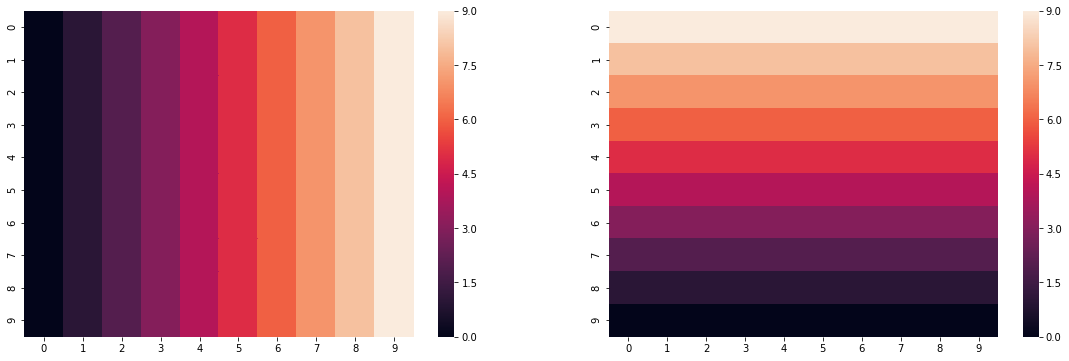

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12*1.6, 6))
sns.heatmap(beta1, ax=ax[0])
sns.heatmap(beta2, ax=ax[1])
plt.show()

This reflects a gradient from left to right, and from bottom to top of a perfectly square grid. While this is highly idealized, we can see how well the model recovers these estimates in the exercise below. 

First, though, let's draw some random normal data for the exercise and construct our $y$ vector, letting $\tau^2=1$. 

In [5]:
x1, x2 = np.random.normal(0,1,size=(100,2)).T

In [6]:
x1 = x1.reshape(100,1)
x2 = x2.reshape(100,1)

In [7]:
flat_beta1 = beta1.flatten().reshape(100,1)
flat_beta2 = beta2.flatten().reshape(100,1)

In [8]:
y = x1 * flat_beta1 + x2 * flat_beta2 + np.random.normal(0,1,size=(100,1))

The aspatial distribution of our data does not betray any specific trending, since we've ensured that our $\beta_1$ and $\beta_2$ surfaces are perfectly independent of one another:

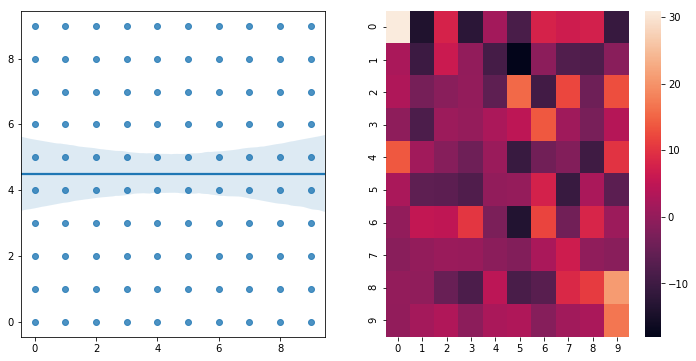

In [9]:
f,ax = plt.subplots(1,2, figsize=(12,6))
sns.heatmap(y.reshape(10,10), ax=ax[1])
sns.regplot(beta1.flatten(), beta2.flatten(), ax=ax[0])

So, before we sample, let's assemble our data matrix and our coordinates. The coordinates are used to compute the spatial kernel function, $\mathbf{H}(\phi)$, which models the spatial similarity in the random component of $\beta$ in space. 

In [10]:
positions = np.array(list(zip(flat_beta1.flatten(),
                              flat_beta2.flatten())))
X = np.hstack((x1, x2))

We can sample multiple traces in parallel using `spvcm`, so below, we will see progressbars for each of the chains independently:

In [11]:
import time as t
m = SVC(y, X, positions, n_samples=0, 
        starting_values=dict(Phi=.5), 
        configs=dict(jump=.2))
start = t.time()
m.sample(2000, n_jobs=4)
end = t.time() - start
print('{} seconds elapsed'.format(end))

100%|██████████| 2000/2000 [02:32<00:00, 43.02it/s]


152.74864077568054 seconds elapsed


We can see the structure of the model below, with our traceplots showing the sample paths, and the Kernel density estimates on right:

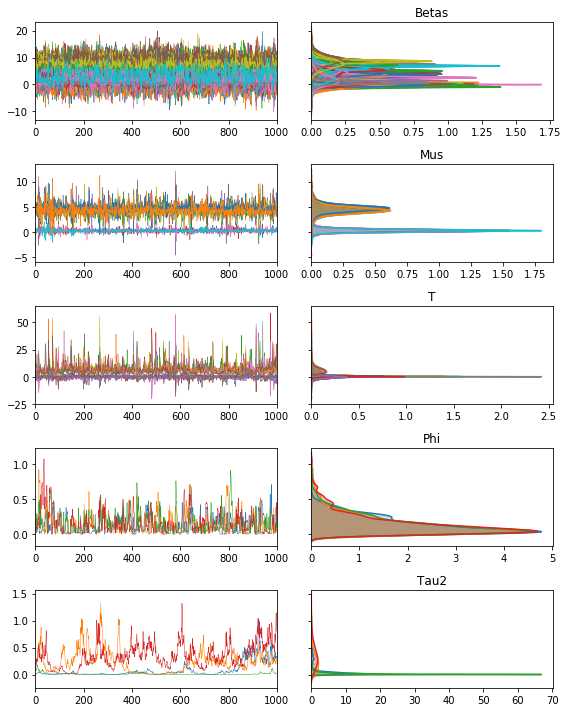

In [12]:
m.trace.plot(burn=1000)
plt.tight_layout()
plt.show()

Further, we can extract our estimatesfrom the trace:

In [13]:
a,b,c,d = np.squeeze(m.trace['Betas'])

In [14]:
est_b0s = np.squeeze(m.trace['Betas'])[:,:,::3].mean(axis=1)
est_b1s = np.squeeze(m.trace['Betas'])[:,:,1::3].mean(axis=1)
est_b2s = np.squeeze(m.trace['Betas'])[:,:,2::3].mean(axis=1)

And verify that the estimates from all of our chains, though slightly different, look like our target surfaces:

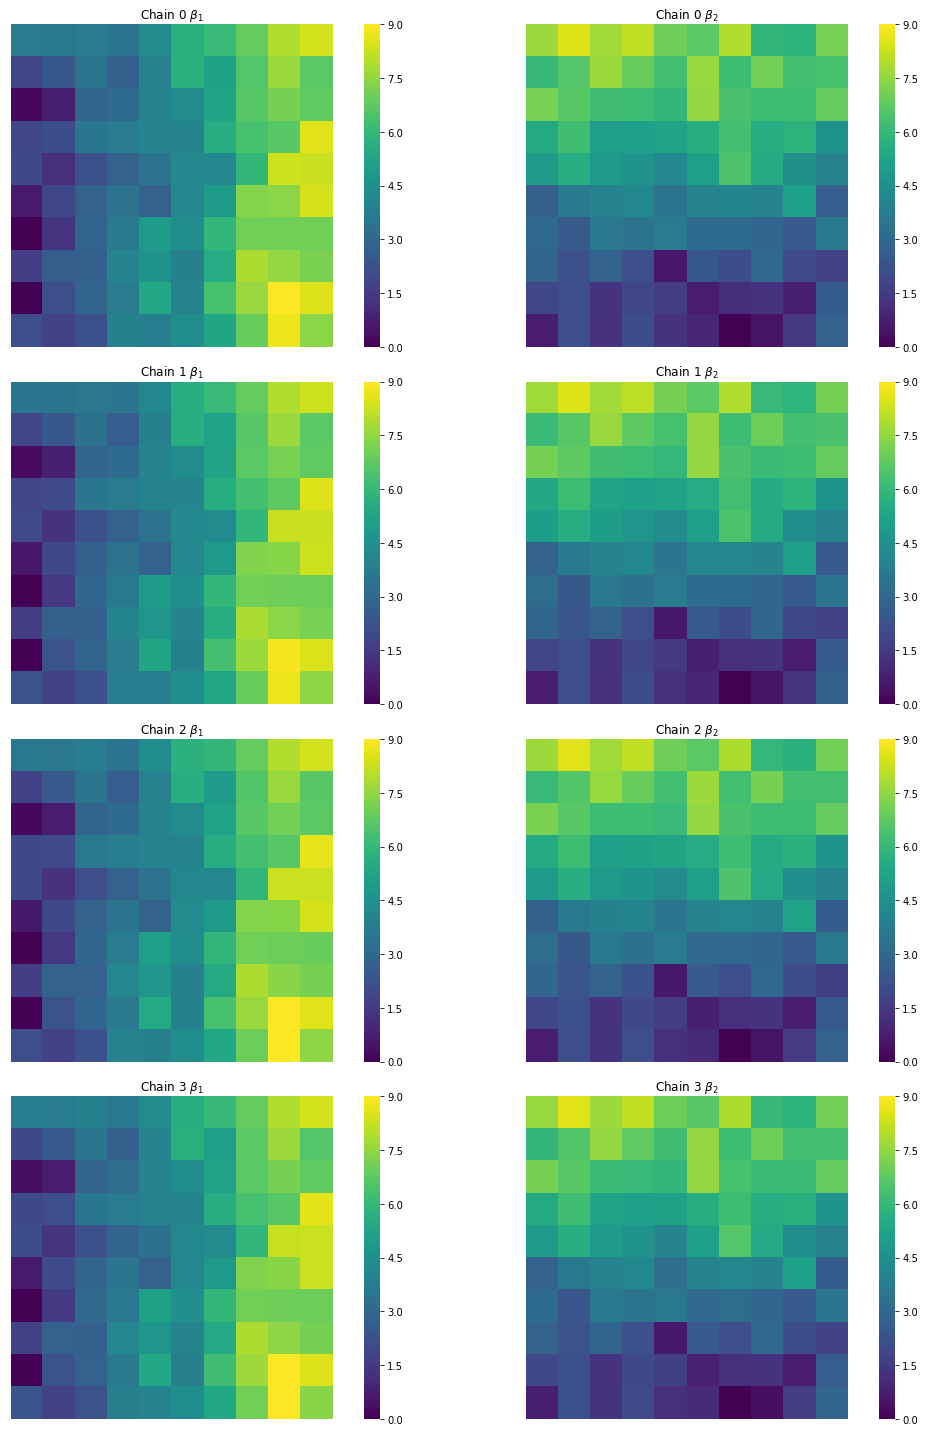

In [15]:
f,ax = plt.subplots(4,2, figsize=(16,20), 
                    subplot_kw=dict(aspect='equal'))
cfgs = dict(xticklabels='', yticklabels='', 
            vmin=0, vmax=9, cmap='viridis')
for i, (b1,b2) in enumerate(zip(est_b1s, est_b2s)):
    sns.heatmap(b1.reshape(10,10),ax=ax[i,0], cbar=True, **cfgs)
    sns.heatmap(b2.reshape(10,10), ax=ax[i,1], cbar=True, **cfgs)
    ax[i,0].set_title('Chain {} $\\beta_1$'.format(i))
    ax[i,1].set_title('Chain {} $\\beta_2$'.format(i))
plt.tight_layout()
plt.show()

Finally, it is important that our prediction error in the $\hat{\beta_i}$ estimates are uncorrelated. Below, we can see that, in the map, the surfaces are indeed spatially random:

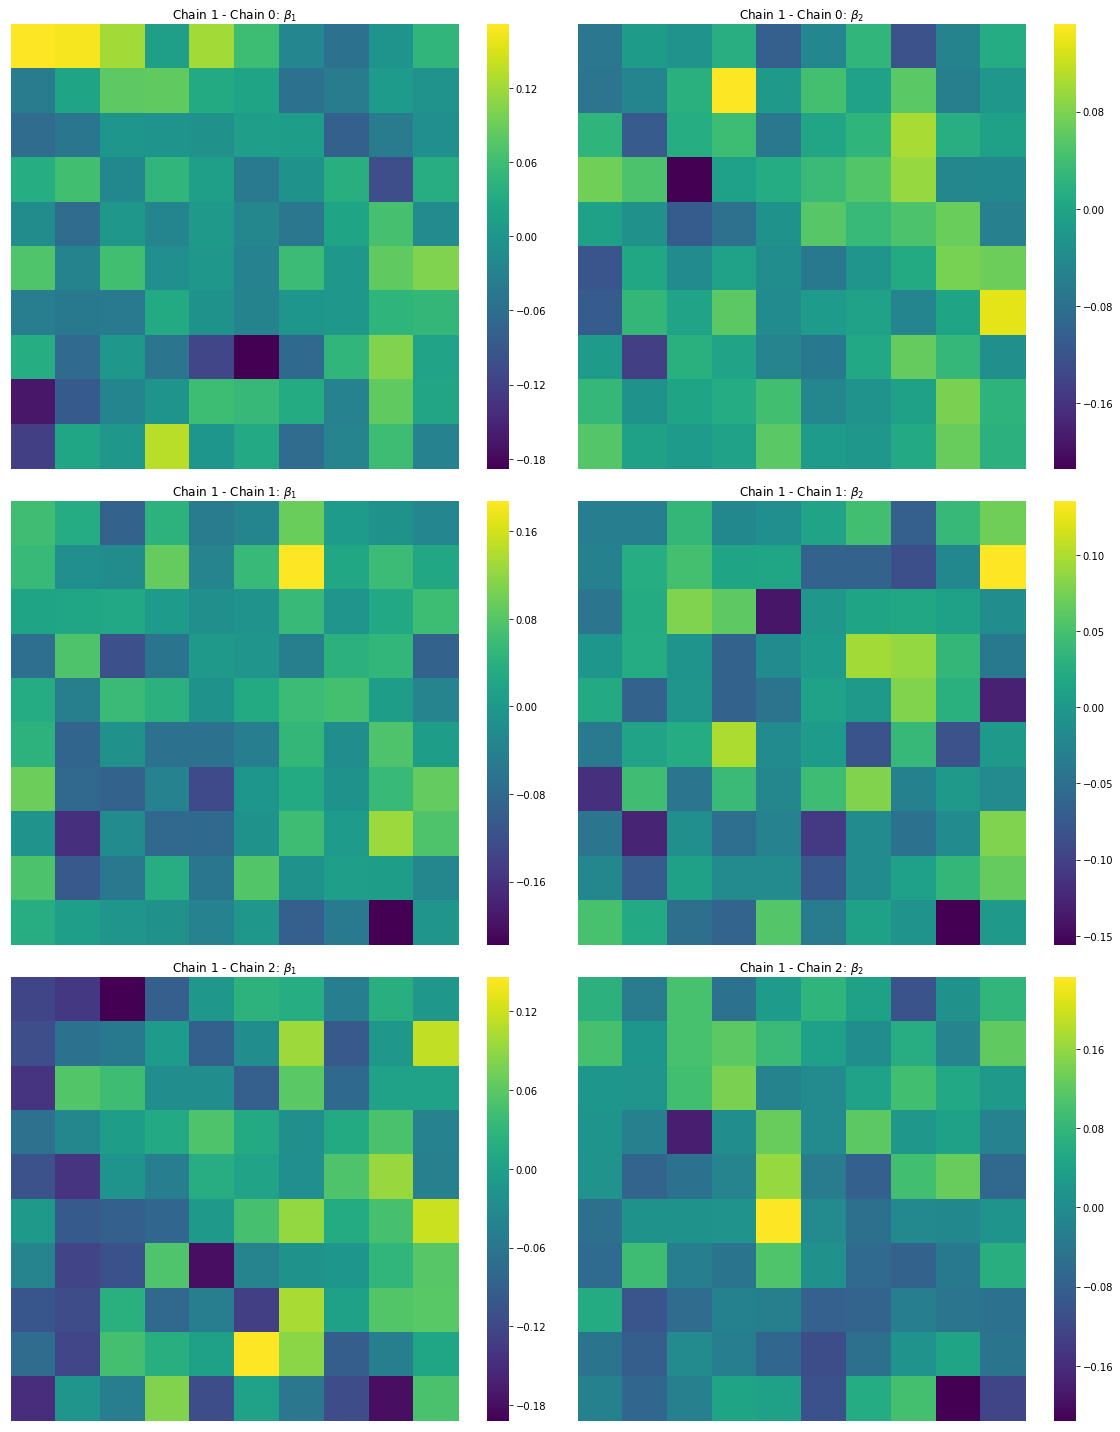

In [16]:
f,ax = plt.subplots(3,2, figsize=(16,20))
cfgs = dict(xticklabels='', yticklabels='', 
            vmin=None, vmax=None, cmap='viridis')
b1ref = est_b1s[0].reshape(10,10)
b2ref = est_b2s[0].reshape(10,10)
for i, (b1,b2) in enumerate(zip(est_b1s[1:], est_b2s[1:])):
    sns.heatmap(b1ref - b1.reshape(10,10),ax=ax[i,0], cbar=True, **cfgs)
    sns.heatmap(b2ref - b2.reshape(10,10), ax=ax[i,1], cbar=True, **cfgs)
    ax[i,0].set_title('Chain 1 - Chain {}: $\\beta_1$'.format(i))
    ax[i,1].set_title('Chain 1 - Chain {}: $\\beta_2$'.format(i))
plt.tight_layout()
plt.show()

Finally, we can see that the true and estimated values are strongly correlated:

[Text(0.5,1,'Chain 0'),
 Text(0.5,1,'Chain 1'),
 Text(0.5,1,'Chain 2'),
 Text(0.5,1,'Chain 3')]

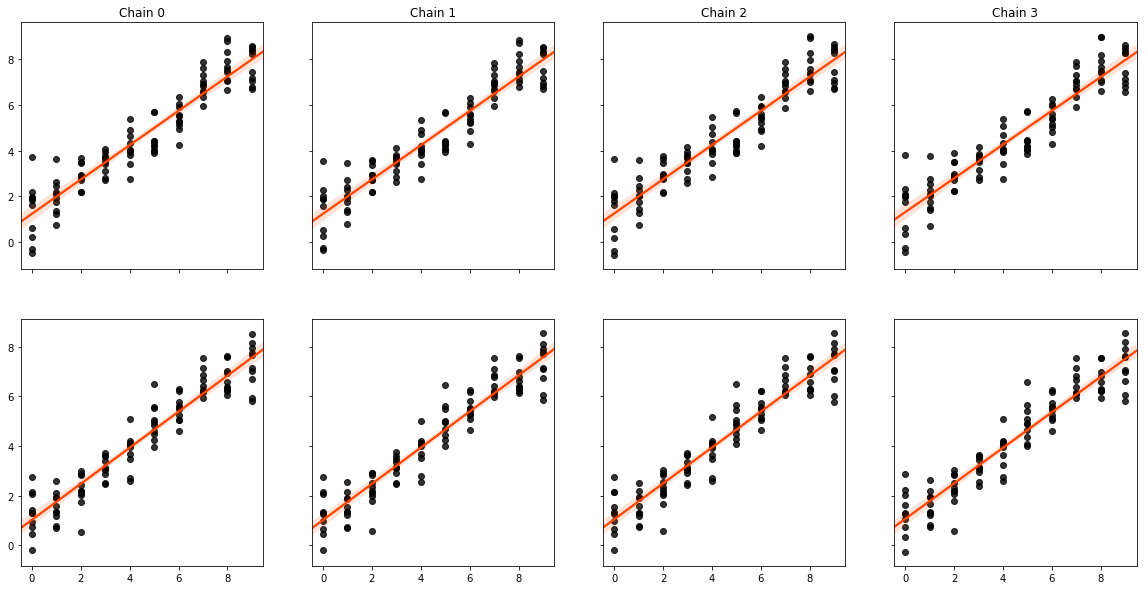

In [17]:
f,ax = plt.subplots(2,4, figsize=(20,10), sharex=True, sharey='row')
[sns.regplot(beta1.flatten(), est_b1.flatten(), color='k', 
             line_kws=dict(color='orangered'), ax=subax) 
             for est_b1,subax in zip(est_b1s, ax[0])]
[sns.regplot(beta2.flatten(), est_b2.flatten(), color='k', 
             line_kws=dict(color='orangered'), ax=subax) 
             for est_b2,subax in zip(est_b2s, ax[1])]
[subax.set_title("Chain {}".format(i)) for i,subax in enumerate(ax[0])]